In [11]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf

#다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

#학습용/평가용 데이터 분리: train, test
from sklearn.model_selection import train_test_split

# 선형회귀모형
from sklearn.linear_model import LinearRegression

#변수 선택법(후진제거법)
from sklearn.feature_selection import RFE

#scale 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler

# 평가함수
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# 과제 1

In [2]:
#1. 데이터 구성하기
df = pd.read_csv("../data/체질검사.csv")
df.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [3]:
df['WEIGHT']*0.45

0      163.4175
1       75.6000
2       79.9875
3       66.4875
4       98.5500
         ...   
247     93.3750
248     76.8375
249     73.2375
250     75.4875
251     75.6000
Name: WEIGHT, Length: 252, dtype: float64

In [4]:
df['HEIGHT']*2.54

0      183.515
1      180.975
2      173.990
3      167.005
4      162.560
        ...   
247    177.800
248    171.450
249    167.640
250    173.990
251    181.610
Name: HEIGHT, Length: 252, dtype: float64

In [5]:
#2. 파생변수 BMI 추가
df['BMI'] = df['WEIGHT']*0.45 / (df['HEIGHT']*2.54/100).pow(2)

In [6]:
df

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.523870
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,31.9,74,207.50,70.00,40.8,112.4,108.5,107.1,59.3,42.2,24.6,33.7,30.0,20.9,29.537049
248,23.6,43,170.75,67.50,37.4,103.7,89.7,94.2,58.5,39.0,24.1,33.8,28.8,18.8,26.139558
249,20.9,35,162.75,66.00,36.4,99.1,92.8,99.2,63.1,38.7,21.7,31.1,26.4,16.9,26.060228
250,17.0,56,167.75,68.50,37.4,98.6,93.0,97.0,55.4,38.8,23.2,32.4,29.7,19.0,24.935981


In [ ]:
#2. 변수 간의 경향성 파악: 그래프 분석(1)
sns.pairplot(df)

In [7]:
#2. 변수 간의 경향성 파악: 상관관계 분석(2)
df.corr().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
FAT,1.000,0.291,0.612,-0.089,0.491,0.703,0.813,0.625,0.560,0.509,0.266,0.493,0.361,0.347,0.371
AGE,0.291,1.000,-0.013,-0.172,0.114,0.176,0.230,-0.050,-0.200,0.018,-0.105,-0.041,-0.085,0.214,0.040
WEIGHT,0.612,-0.013,1.000,0.308,0.831,0.894,0.888,0.941,0.869,0.853,0.614,0.800,0.630,0.730,0.391
HEIGHT,-0.089,-0.172,0.308,1.000,0.254,0.135,0.088,0.170,0.148,0.286,0.265,0.208,0.229,0.322,-0.638
NECK,0.491,0.114,0.831,0.254,1.000,0.785,0.754,0.735,0.696,0.672,0.478,0.731,0.624,0.745,0.266
CHEST,0.703,0.176,0.894,0.135,0.785,1.000,0.916,0.829,0.730,0.719,0.483,0.728,0.580,0.660,0.383
ABDOMEN,0.813,0.230,0.888,0.088,0.754,0.916,1.000,0.874,0.767,0.737,0.453,0.685,0.503,0.620,0.415
HIP,0.625,-0.050,0.941,0.170,0.735,0.829,0.874,1.000,0.896,0.823,0.558,0.739,0.545,0.630,0.462
THIGH,0.560,-0.200,0.869,0.148,0.696,0.730,0.767,0.896,1.000,0.799,0.540,0.761,0.567,0.559,0.433
KNEE,0.509,0.018,0.853,0.286,0.672,0.719,0.737,0.823,0.799,1.000,0.612,0.679,0.556,0.665,0.364


### FAT와 CHEST, ABDOMEN 간에 높은 선형관계가 확인되었다.
### 또한, WEIGHT와 여러 설명변수 간의 선형관계가 확인되었기에 다중공선성 확인 및 처리가 필요하다.

In [8]:
#3. train/test 데이터 분리
df_train, df_test = train_test_split(df, test_size=0.4, random_state=1234)
print("train data size: {}".format(df_train.shape))
print("test data size: {}".format(df_test.shape))

train data size: (151, 15)
test data size: (101, 15)


In [9]:
#4. 회귀 모델 생성
formula = "FAT ~ AGE + WEIGHT + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                KNEE + ANKLE + BICEPS + FOREARM + WRIST + BMI"
reg_model = smf.ols(formula, data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     31.77
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           5.19e-36
Time:                        18:52:15   Log-Likelihood:                -424.76
No. Observations:                 151   AIC:                             879.5
Df Residuals:                     136   BIC:                             924.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -51.7190     31.607     -1.636      0.1

### Prob(Omnibus) 값이 0.05보다 크므로 정규성이라는 것을 알 수 있으며
### Durbin-Watson 값이 2에 가깝기에 변수 간 독립성이 존재한다는 것을 파악할 수 있다.

In [12]:
#5. 설명변수 간 다중공선성 확인
df_train_x = df_train.drop("FAT", axis=1)

#1) statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)

#2) VIF를 DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif['Variable'] = df_train_x_const.columns
df_vif['VIF']= [variance_inflation_factor(df_train_x_const.values, i)\
               for i in range(df_train_x_const.shape[1])]
#3) VIF 정렬
df_vif.sort_values("VIF", ascending=True).round(2)

,Variable,VIF
12,FOREARM,1.91
10,ANKLE,2.22
1,AGE,2.37
11,BICEPS,3.38
13,WRIST,3.45
4,NECK,4.59
9,KNEE,5.32
8,THIGH,9.26
14,BMI,10.30
5,CHEST,11.51


###  WEIGHT의 VIF가 56.45로 높게 나타나기에 모델에서 제외해본다.

In [13]:
#6. 회귀 모델 생성 - WEIGHT 제거
formula = "FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                KNEE + ANKLE + BICEPS + FOREARM + WRIST + BMI"
reg_model = smf.ols(formula, data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     33.35
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           4.56e-36
Time:                        19:06:04   Log-Likelihood:                -426.64
No. Observations:                 151   AIC:                             881.3
Df Residuals:                     137   BIC:                             923.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2911     10.937      0.301      0.7

In [14]:
#7. 설명변수 간 다중공선성 재확인
df_train_x = df_train.drop(["FAT", "WEIGHT"], axis=1)

#1) statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)

#2) VIF를 DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif['Variable'] = df_train_x_const.columns
df_vif['VIF']= [variance_inflation_factor(df_train_x_const.values, i)\
               for i in range(df_train_x_const.shape[1])]
#3) VIF 정렬
df_vif.sort_values("VIF", ascending=True).round(2)

,Variable,VIF
11,FOREARM,1.91
9,ANKLE,2.03
1,AGE,2.34
10,BICEPS,3.20
12,WRIST,3.43
3,NECK,3.90
8,KNEE,5.20
2,HEIGHT,6.76
13,BMI,6.79
7,THIGH,9.09


### 위에서 출력한 분산분석 결과를 보면, HIP과 ABDOMEN의 p-value값은 각각  0.035와 0.000이기에 0.05보다 작다.
### 따라서 목표변수에 영향을 주는 변수들이기에 제거하지 않는다.

In [15]:
#8. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#1) BICEPS 제거
formula = "FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                KNEE + ANKLE + FOREARM + WRIST + BMI"
reg_model = smf.ols(formula, data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     36.38
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           7.53e-37
Time:                        19:18:26   Log-Likelihood:                -426.66
No. Observations:                 151   AIC:                             879.3
Df Residuals:                     138   BIC:                             918.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9134     10.741      0.271      0.7

In [16]:
#2) BMI 제거
formula = "FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                KNEE + ANKLE + FOREARM + WRIST"
reg_model = smf.ols(formula, data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     39.88
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           1.32e-37
Time:                        19:18:56   Log-Likelihood:                -426.80
No. Observations:                 151   AIC:                             877.6
Df Residuals:                     139   BIC:                             913.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0847      9.183      0.009      0.9

In [17]:
#3) ANKLE 제거
formula = "FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                KNEE + FOREARM + WRIST"
reg_model = smf.ols(formula, data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     44.06
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           2.22e-38
Time:                        19:19:17   Log-Likelihood:                -426.96
No. Observations:                 151   AIC:                             875.9
Df Residuals:                     140   BIC:                             909.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1133      9.152     -0.012      0.9

In [18]:
#4) CHEST 제거
formula = "FAT ~ AGE + HEIGHT + NECK + ABDOMEN + HIP + THIGH +\
                KNEE + FOREARM + WRIST"
reg_model = smf.ols(formula, data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     49.08
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           3.88e-39
Time:                        19:20:42   Log-Likelihood:                -427.22
No. Observations:                 151   AIC:                             874.4
Df Residuals:                     141   BIC:                             904.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6777      9.064      0.075      0.9

In [20]:
#5) KNEE 제거
formula = "FAT ~ AGE + HEIGHT + NECK + ABDOMEN + HIP + THIGH +\
                FOREARM + WRIST"
reg_model = smf.ols(formula, data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     55.26
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           7.06e-40
Time:                        19:21:06   Log-Likelihood:                -427.58
No. Observations:                 151   AIC:                             873.2
Df Residuals:                     142   BIC:                             900.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2832      8.979     -0.032      0.9

In [21]:
#6) THIGH 제거
formula = "FAT ~ AGE + HEIGHT + NECK + ABDOMEN + HIP +\
                FOREARM + WRIST"
reg_model = smf.ols(formula, data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     62.88
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           1.56e-40
Time:                        19:21:41   Log-Likelihood:                -428.23
No. Observations:                 151   AIC:                             872.5
Df Residuals:                     143   BIC:                             896.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0145      8.982      0.002      0.9

In [22]:
#7) AGE 제거
formula = "FAT ~ HEIGHT + NECK + ABDOMEN + HIP +\
                FOREARM + WRIST"
reg_model = smf.ols(formula, data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     72.41
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           5.07e-41
Time:                        19:22:16   Log-Likelihood:                -429.37
No. Observations:                 151   AIC:                             872.7
Df Residuals:                     144   BIC:                             893.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3613      8.249      0.650      0.5

In [23]:
#8) WRIST 제거
formula = "FAT ~ HEIGHT + NECK + ABDOMEN + HIP +\
                FOREARM"
reg_model = smf.ols(formula, data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     85.90
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           1.39e-41
Time:                        19:23:00   Log-Likelihood:                -430.41
No. Observations:                 151   AIC:                             872.8
Df Residuals:                     145   BIC:                             890.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7198      7.865      0.219      0.8

### p-value값이 0.05보다 작은 변수들만 남긴다. 즉, 통계적으로 무의미한 변수들은 모두 제거한다.

In [27]:
#9. 설명변수 간 다중공선성 재확인
df_train_x = df_train[["HEIGHT", "NECK", "ABDOMEN", "HIP", "FOREARM"]]

#1) statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)

#2) VIF를 DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif['Variable'] = df_train_x_const.columns
df_vif['VIF']= [variance_inflation_factor(df_train_x_const.values, i)\
               for i in range(df_train_x_const.shape[1])]
#3) VIF 정렬
df_vif.sort_values("VIF", ascending=True).round(2)

,Variable,VIF
1,HEIGHT,1.14
5,FOREARM,1.46
2,NECK,2.84
4,HIP,4.63
3,ABDOMEN,4.89
0,const,512.16


### 모든 변수의 VIF가 10 미만이므로 다중공선성 해결

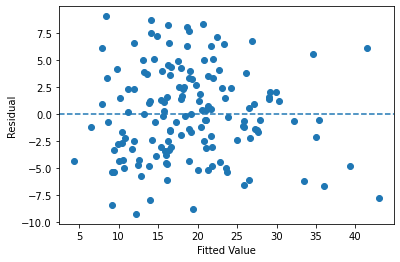

In [28]:
#10. 회귀 모델 생성 - 잔차의 가정 확인
#1) 등분산성 확인
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("Fitted Value")
plt.ylabel("Residual")
plt.axhline(y=0, linestyle="--")

### y=0을 기준으로 랜덤하게 산포되어 있기에 등분산성을 만족한다.

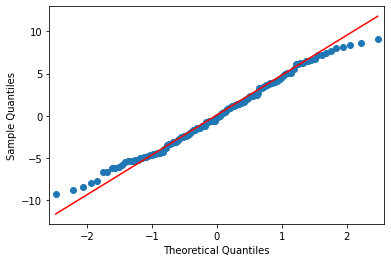

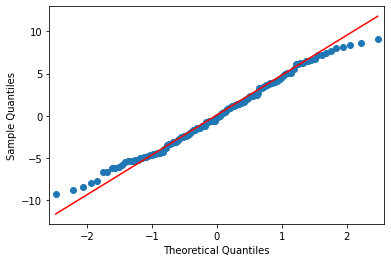

In [29]:
#2) 정규성 검정
qqplot(reg_result.resid, line='q')

### 잔차가 정규분포 직선을 중심으로 분포하기에 정규성을 만족한다.

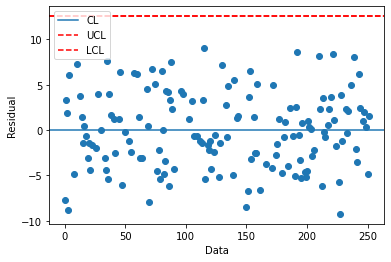

In [32]:
#3) 독립성 검정
plt.scatter(df_train.index, reg_result.resid)
plt.xlabel("Data")
plt.ylabel("Residual")
plt.axhline(y=0, linestyle="-", label="CL")
plt.axhline(y=3*np.std(reg_result.resid), linestyle="--", color="red", label="UCL")
plt.axhline(y=3*np.std(reg_result.resid), linestyle="dashed", color="red", label="LCL")
plt.legend()

### 잔차가 y=0을 기준으로 관리상하한을 벗어나지 않고 랜덤하게 산포되어 있으므로 독립성을 만족한다.

In [35]:
#11. 회귀 모델의 성능 확인
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정계수: {0:.3f}".format(r2_score(df_train['FAT'], train_pred)))
print("test data의 결정계수: {0:.3f}".format(r2_score(df_test['FAT'], test_pred)))

train data의 결정계수: 0.748
test data의 결정계수: 0.691


<AxesSubplot:>

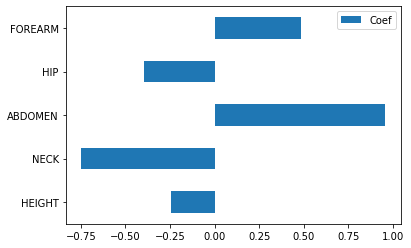

In [36]:
#12. 결론 도출
df_reg_coef = pd.DataFrame({"Coef": reg_result.params.values[1:]},
                           index=['HEIGHT', 'NECK', 'ABDOMEN', 'HIP', 'FOREARM'])
df_reg_coef.plot.barh(y='Coef')